# Разработка A/B-тестирования и анализ результатов


### Цель проекта заключается в разработке и расчёте параметров A/B-теста, который позволит проверить гипотезу: внедрение нового алгоритма рекомендаций увеличит долю успешных сессий, когда за одну сессию было просмотрено 4 и более страниц, и проанализировать его результаты.

## Описание данных

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

- Основной метрикой, изменение которой ожидается в ходе проведения A/B-тестирования, будет выступать увеличение доли сессий с четырьмя и более просмотренными страницами. Увеличение этой метрики будет отражать интерес пользователей к нововведению.
- Отследить изменения числа сессий в день. Необходимо убедиться, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимые.
- В A/B-тест будет вовлечена вся аудитория приложения, будут учтены все регионы и все виды устройств.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [3]:
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


#### 1.2. Знакомство с данными

In [4]:
count_unique_session_id = sessions_history.groupby('user_id')['session_id'].nunique()

In [5]:
sessions_history.duplicated().sum()

0

In [6]:
max_user_id = count_unique_session_id.idxmax()
data_max_user_id = sessions_history[sessions_history['user_id'] == max_user_id]
data_max_user_id

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


In [7]:
data_max_user_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 115558 to 414743
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            10 non-null     object
 1   session_id         10 non-null     object
 2   session_date       10 non-null     object
 3   session_start_ts   10 non-null     object
 4   install_date       10 non-null     object
 5   session_number     10 non-null     int64 
 6   registration_flag  10 non-null     int64 
 7   page_counter       10 non-null     int64 
 8   region             10 non-null     object
 9   device             10 non-null     object
dtypes: int64(3), object(7)
memory usage: 880.0+ bytes


После знакомства с данными можно сделать вывод, что значения в столбцах соответствуют своему описанию, а так же стоит поменять формат даты на более привычный

#### 1.3. Анализ числа регистраций

In [8]:
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])
daily_sessions_history = sessions_history.groupby('session_date').agg(unique_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')).reset_index()

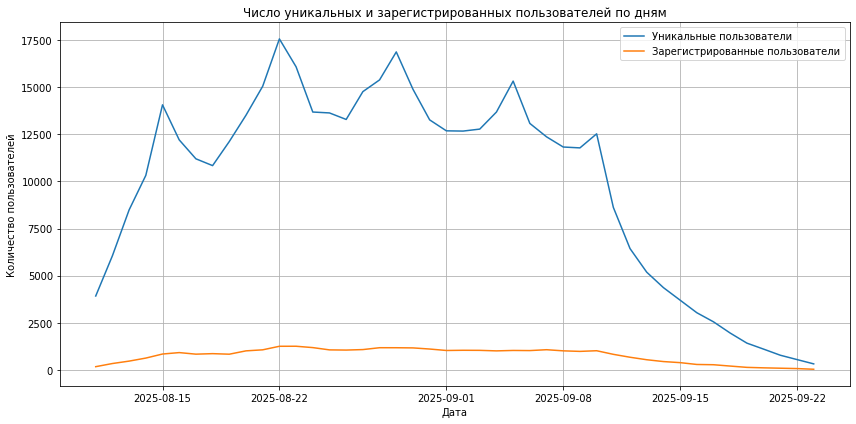

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(daily_sessions_history['session_date'], daily_sessions_history['unique_users'], label='Уникальные пользователи')
plt.plot(daily_sessions_history['session_date'], daily_sessions_history['registered_users'], label='Зарегистрированные пользователи')
plt.title('Число уникальных и зарегистрированных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

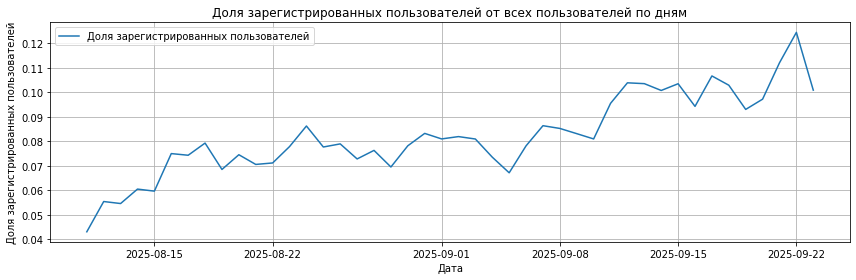

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(daily_sessions_history['session_date'], daily_sessions_history['registered_users'] / daily_sessions_history['unique_users'], label='Доля зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей')
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### 1.4. Анализ числа просмотренных страниц

In [11]:
count_pages_sessions_history = sessions_history['page_counter'].value_counts().sort_index()
count_pages_sessions_history

1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: page_counter, dtype: int64

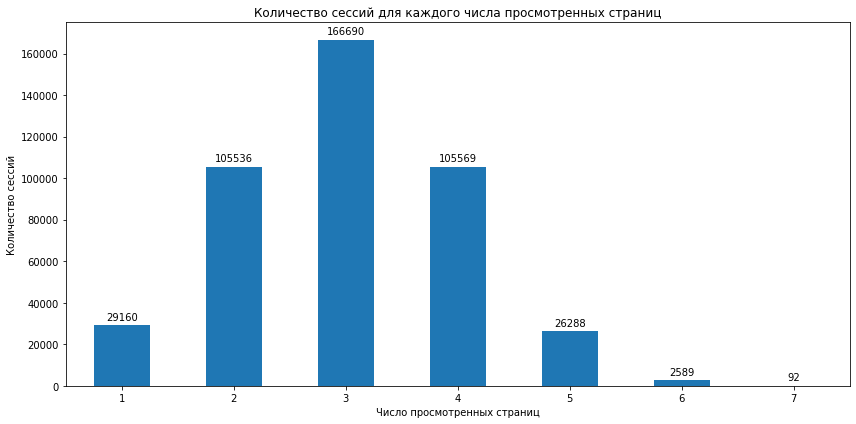

In [12]:
plt.figure(figsize=(12, 6))
count_pages_sessions_history.plot(kind='bar')
for i, v in enumerate(count_pages_sessions_history.values):
    count_pages_sessions_history.plot(kind='bar').text(i, v + 0.01 * max(count_pages_sessions_history.values), str(v), ha='center', va='bottom')
plt.title('Количество сессий для каждого числа просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [13]:
sessions_history["good_session"] = np.where(sessions_history["page_counter"] >= 4, 1, 0)

In [14]:
mean_all = sessions_history["good_session"].mean()
mean_last_period = sessions_history.tail(7)["good_session"].mean()
print(f"Среднее за весь период: {mean_all}")
print(f"Среднее за последний период: {mean_last_period}")

Среднее за весь период: 0.30862719189583504
Среднее за последний период: 0.5714285714285714


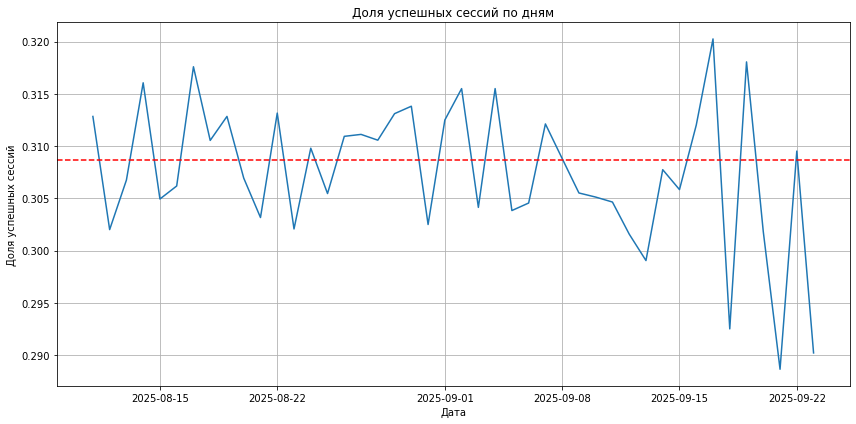

In [15]:
share_of_successful_session = sessions_history.groupby('session_date')['good_session'].mean().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(share_of_successful_session['session_date'], share_of_successful_session['good_session'])
plt.axhline(mean_all, color='red', linestyle='--', label="Среднее значение")
plt.title('Доля успешных сессий по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid()
plt.tight_layout()
plt.show()

In [16]:
std_dev = sessions_history["good_session"].std()
print(f"Стандартное отклонение: {std_dev}")

Стандартное отклонение: 0.46192741616004496


### 2. Подготовка к тесту

#### 2.1 Формулировка нулевой и альтернативной гипотез

- Целевой метрикой будет выступать увеличение доли успешных сессий, когда за одну сессию было просмотрено 4 и более страниц. Увеличение этой метрики будет отражать интерес пользователей к нововведению.

- Нулевая гипотеза (H0) - Новый алгоритм рекомендаций не оказывает значительного влияния на просмотр страниц во время сессии, по сравнению с текущим алгоритмом.
- Альтернативная гипотеза (H1) - Внедрение нового алгоритма рекомендаций увеличит долю успешных сессий, когда за одну сессию было просмотрено 4 и более страниц.

#### 2.2. Расчёт размера выборки

In [17]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = p1 * 0.03  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


При уровне значимости - 0.05, ошибке второго рода - 0.2, мощности теста - 0.8, базовом уровне доли - 0.3 и минимальном детектируемом эффекте - 0.03, получен необходимый размер выборки для каждой группы - 41040.

#### 2.3. Расчёт длительности A/B-теста

In [18]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby('session_date')['user_id'].nunique().mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

In [19]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [20]:
unique_users_test_group = sessions_test_part.groupby('test_group')['user_id'].nunique()
unique_users_test_group

test_group
A    1477
B    1466
Name: user_id, dtype: int64

In [21]:
percent_diff_unique_users_test_group = 100 * abs(unique_users_test_group.get('A') - unique_users_test_group.get('B')) / unique_users_test_group.get('A')
print(f"Процентная разница в количестве пользователей между группами A и B: {percent_diff_unique_users_test_group:.2f}%")

Процентная разница в количестве пользователей между группами A и B: 0.74%


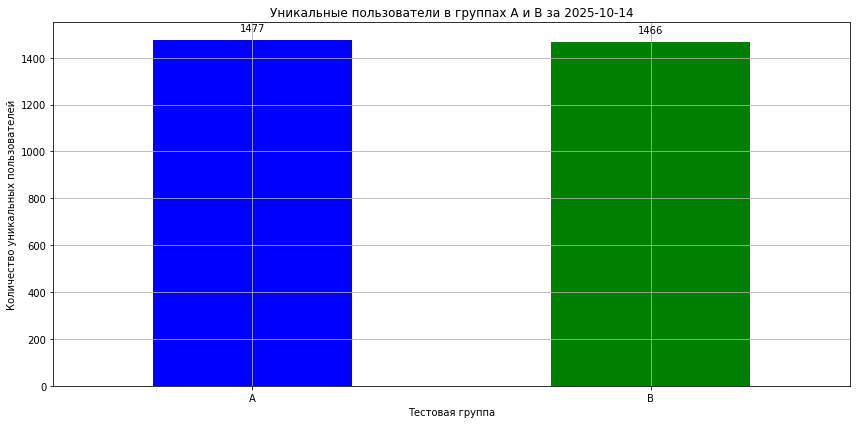

In [22]:
plt.figure(figsize=(12, 6))
for i, v in enumerate(unique_users_test_group.values):
    unique_users_test_group.plot(kind='bar').text(i, v + 0.02 * max(unique_users_test_group.values), str(v), ha='center', va='bottom')
unique_users_test_group.plot(kind='bar', color=['blue', 'green'])
plt.title(f'Уникальные пользователи в группах A и B за 2025-10-14')
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Тестовая группа')
plt.xticks(rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

#### 3.2. Проверка пересечений пользователей

In [23]:
test_group_A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
test_group_B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(test_group_A) & set(test_group_B))
print(intersection) 

[]


#### 3.3. Равномерность разделения пользователей по устройствам

In [24]:
unique_users_device = sessions_test_part[['user_id', 'device', 'test_group']].drop_duplicates(subset='user_id')
group_a_device = unique_users_device[unique_users_device['test_group'] == 'A']
group_b_device = unique_users_device[unique_users_device['test_group'] == 'B']
device_test_a = group_a_device['device'].value_counts(normalize=True) * 100
device_test_b = group_b_device['device'].value_counts(normalize=True) * 100

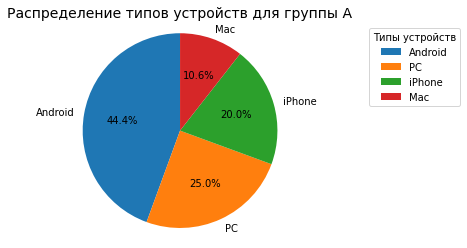

In [25]:
plt.pie(device_test_a, labels=device_test_a.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение типов устройств для группы A', fontsize=14)
plt.axis('equal')
plt.legend(title='Типы устройств', bbox_to_anchor=(1.05, 1), loc='upper left')

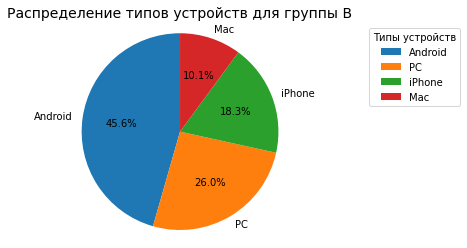

In [26]:
plt.pie(device_test_b, labels=device_test_b.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение типов устройств для группы B', fontsize=14)
plt.axis('equal')
plt.legend(title='Типы устройств', bbox_to_anchor=(1.05, 1), loc='upper left')

#### 3.4. Равномерность распределения пользователей по регионам

In [27]:
unique_users_regions = sessions_test_part[['user_id', 'region', 'test_group']].drop_duplicates(subset='user_id')
group_a_region = unique_users_regions[unique_users_regions['test_group'] == 'A']
group_b_region = unique_users_regions[unique_users_regions['test_group'] == 'B']
region_test_a = group_a_region['region'].value_counts(normalize=True) * 100
region_test_b = group_b_region['region'].value_counts(normalize=True) * 100

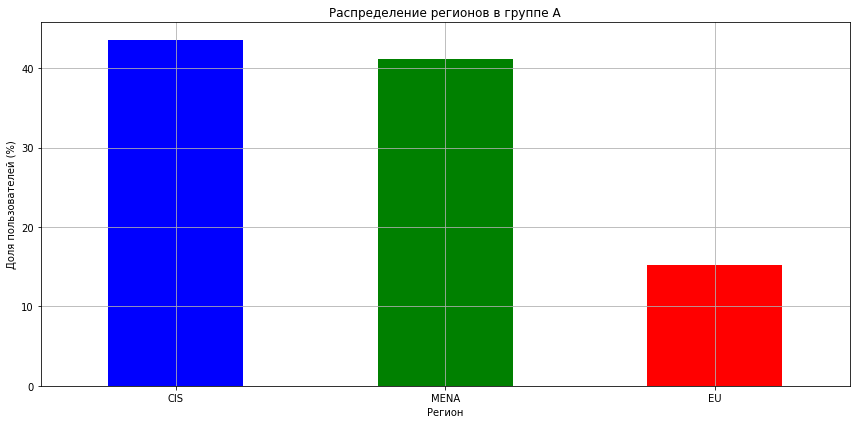

In [28]:
plt.figure(figsize=(12, 6))
region_test_a.plot(kind='bar', color=['blue', 'green', 'red'])
plt.title('Распределение регионов в группе A')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей (%)')
plt.xticks(rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

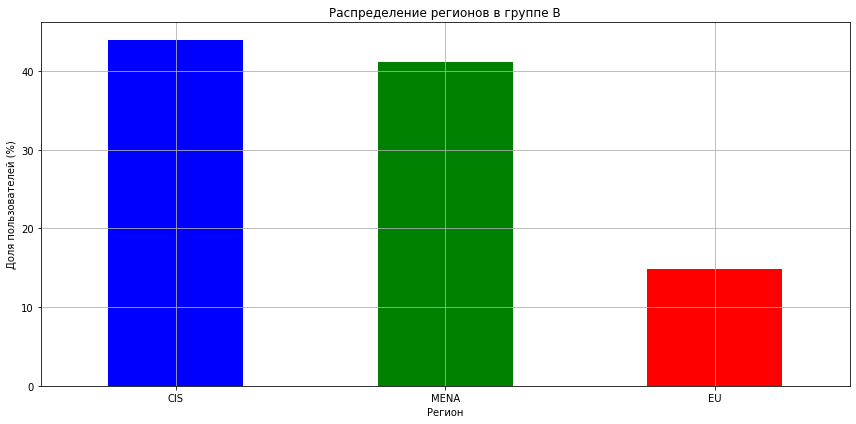

In [29]:
plt.figure(figsize=(12, 6))
region_test_b.plot(kind='bar', color=['Blue', 'Green','red'])
plt.title('Распределение регионов в группе B')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей (%)')
plt.xticks(rotation=0)
plt.grid()
plt.tight_layout()
plt.show()

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста, можно сделать следующие выводы:
- Различие в количестве пользователей в двух группах незначительное и в процентном соотношении составляет: 0.74%. В группе A - 1477 пользователей, в группе B - 1466 пользователей.
- Выборки являются независимыми, пересечение пользователей из тестовой и контрольной групп отсутствует.
- Распределение распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионами отличается, но незначительно, различие не более 2%, что говорит о равномерном распределении.

Можно сделать вывод, что A/B-тест проходит корректно, нарушений не наблюдается.

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [30]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [31]:
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

#### 4.2. Проверка корректности результатов теста

In [32]:
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])
daily_sessions_test = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()

In [33]:
sessions_test_a = daily_sessions_test[daily_sessions_test['test_group'] == 'A']['session_id']
sessions_test_b = daily_sessions_test[daily_sessions_test['test_group'] == 'B']['session_id']
stat_ttest, p_value_ttest = ttest_ind(sessions_test_a, sessions_test_b, alternative='less')
print(f"Полученное значение p-value = {round(p_value_ttest, 2)}")
alpha = 0.05
if p_value_ttest < alpha:
    print("Существует различие в количестве уникальных сессий между группами A и B.")
else:
    print("Нет различий в количестве уникальных сессий между группами A и B.")
print(f'При внедрении нового алгоритма количество сессий в обеих выборках не различалось.')

Полученное значение p-value = 0.47
Нет различий в количестве уникальных сессий между группами A и B.
При внедрении нового алгоритма количество сессий в обеих выборках не различалось.


#### 4.3. Сравнение доли успешных сессий

In [34]:
success_rate_sessions_test_a = sessions_test[sessions_test['test_group'] == 'A']['good_session'].mean()
success_rate_sessions_test_b = sessions_test[sessions_test['test_group'] == 'B']['good_session'].mean()
diff_sessions_test = success_rate_sessions_test_b - success_rate_sessions_test_a
print(f"Доля успешных сессий в группе A: {success_rate_sessions_test_a:.2%}")
print(f"Доля успешных сессий в группе B: {success_rate_sessions_test_b:.2%}")
print(f"Разница в долях успешных сессий (B - A): {diff_sessions_test:.2%}")

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Разница в долях успешных сессий (B - A): 1.06%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

In [35]:
n_a = sessions_test[sessions_test.test_group=='A'].shape[0]
n_b = sessions_test[sessions_test.test_group=='B'].shape[0]
m_a = sessions_test[(sessions_test.test_group=='A')&(sessions_test.good_session==1)].shape[0]
m_b = sessions_test[(sessions_test.test_group=='B')&(sessions_test.good_session==1)].shape[0]
p_a, p_b = m_a/n_a, m_b/n_b
alpha = 0.05
stat_ztest, p_value_ztest = proportions_ztest([m_a, m_b], [n_a, n_b], alternative='smaller')

print(f'pvalue={p_value_ztest:.4f}')

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.0002
Нулевая гипотеза не находит подтверждения!


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проверки результатов A/B-теста, можно сделать следующие выводы:
- В A/B-тесте участвовало 2943 пользователя, в группе А (текущей версии продукта) - 1477 пользователей, в группе B (изменённой версии продукта) - 1466 пользователей. Период эксперимента - с 2025-10-14 по 2025-11-02, длительность - 19 дней. Целевой метрикой является увеличение доли успешных сессий, когда за одну сессию было просмотрено 4 и более страниц. Увеличение этой метрики должно отражать интерес пользователей к нововведению.
- Внедрение нового алгоритма рекомендации повлияла на рост ключевой метрики, но увеличение доли небольшое, рост составляет 1,1%. Доля успешных сессий в группе A составила 30.77%, а в в группе B: 31.83%, разница между ними составила - 1.06%.
- Значение pvalue для оценки статистической значимости выявленного эффекта составило - 0.0002.
- На основе статистического теста можно сделать вывод, что стоит внедрять нововведение в приложение, так как подтвердилась альтернативная гипотеза, которая гласит: Внедрение нового алгоритма рекомендаций увеличит долю успешных сессий, когда за одну сессию было просмотрено 4 и более страниц.